In [1]:
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy
import subprocess
import pandas as pd
from pybedtools import BedTool
sys.path.append('/Users/IEO5559/Desktop/misc/splice/script')
import spl
import pickle
from matplotlib.backends.backend_pdf import PdfPages
from scipy.stats import poisson
from scipy import stats

# params and preprocessing

for the processing below, in general take care, might need to extract params first to see the sample boundaries to make sure the datamatrix fields are extracted correctly, below is assumed that computematrix was run with before=1000 and after=75000. Can check 'params' and re-rerun if necessary

In [2]:
def read(fname):
    matrix = subprocess.run(["gunzip", "-c", "{0}_plus.tab.gz".format(fname), "{0}_minus.tab.gz".format(fname)], capture_output=True, text=True)
    int1 = subprocess.run(["sed", "/^@/d"], input=matrix.stdout, capture_output=True, text=True)
    sortedint1 = subprocess.run(["sort", "-k1,1", "-k2,2n"], input=int1.stdout, capture_output=True, text=True)
    datamatrix = subprocess.run(["cut", "-f", "7-430000"], input=sortedint1.stdout, capture_output=True, text=True)
    data = [i.split("\t") for i in datamatrix.stdout.split("\n")]
    TSS = np.array(data[:-1], dtype=float)     #because of the final newline character
    meta = subprocess.run(["head", "-n", "1"], input=matrix.stdout, capture_output=True, text=True)
    params = meta.stdout 
    print(params)
    
    regions = subprocess.run(["cut", "-f", "4"], capture_output=True, input=sortedint1.stdout, text=True)
    regionlist = regions.stdout.split("\n")[:-1]      #the final newline character
    print(len(regionlist))
    
    bed = subprocess.run(["cut", "-f", "1-6"],capture_output=True, input=sortedint1.stdout, text=True)
    bedint = BedTool(bed.stdout, from_string=True)
    beddf = pd.read_table(bedint.fn, header=None)
    
    return TSS, regionlist, beddf

In [3]:
def godsaveusall(bedfile):
    #take a bedfile from memory and pass to metagene.sh
    bedfile.to_csv('tmp_meta', header=None, index=None, sep="\t")
    subprocess.run(["./metagene.sh", "tmp_meta", "10", "plus", "tmp_meta_plus"])
    subprocess.run(["./metagene.sh", "tmp_meta", "10", "minus", "tmp_meta_minus"])
    both_strands, reglist, beddataframe = read("tmp_meta")
    subprocess.run(["rm","tmp_meta","tmp_meta_plus","tmp_meta_minus", "tmp_meta_plus.pdf","tmp_meta_minus.pdf"])

    return both_strands, reglist, beddataframe

def split(matrix,bins_per_sample,num_samples):
    samples = [matrix[:,(bins_per_sample)*i:(bins_per_sample)*(i+1)] for i in range(num_samples)]
    return samples

def normalise(arr):
    if(np.max(np.array(arr).flatten(order='C'))!=0):
        return arr/(np.max(np.array(arr).flatten(order='C')))
    else:
        return arr

In [4]:
#bothstrands = np.append(plus, minus, axis=0)
#regionlist = list1 + list2
#beddf = pd.concat([beddf1, beddf2])
bps = 210
xbins = list(range(bps))
numsamples = 8
labels = ["CTL","CTL AUX","CPSF3","CPSF3 AUX","CPSF3L","CPSF3L AUX","CPSF3/3L","CPSF3/3L AUX"]
#colors = ['blue', 'blue', 'green', 'green','red', 'red', 'purple', 'purple']
colors = ['black', 'black', 'goldenrod', 'goldenrod','deepskyblue', 'deepskyblue', 'chocolate', 'chocolate']
lstyle = ['dashed','solid','dashed','solid','dashed','solid','dashed','solid']
control_index = 1

# estimate std for each thing for each thing

In [5]:
#if already generated
prefix="allreps/mysiW_filter50_noncod_unnorm"
#prefix="allreps_scale_regions/mysiW_scale_regions"
bothstrandsall, regionlistall, beddfall = read(prefix)

@{"upstream":[1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000],"downstream":[20000,20000,20000,20000,20000,20000,20000,20000,20000,20000,20000,20000,20000,20000,20000,20000,20000,20000,20000,20000,20000,20000,20000,20000],"body":[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],"bin size":[100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100],"ref point":["TSS","TSS","TSS","TSS","TSS","TSS","TSS","TSS","TSS","TSS","TSS","TSS","TSS","TSS","TSS","TSS","TSS","TSS","TSS","TSS","TSS","TSS","TSS","TSS"],"verbose":false,"bin avg type":"mean","missing data as zero":false,"min threshold":null,"max threshold":1000.0,"scale":1,"skip zeros":false,"nan after end":false,"proc number":8,"sort regions":"keep","sort using":"mean","unscaled 5 prime":[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],"unscaled 3 prime":[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],"group_labels":["genes"]

In [6]:
bothstrandsall = np.array(bothstrandsall)
#if scale regions with bps120 
#rep1 = split(bothstrandsall[:,:960], bps, numsamples)
#rep2 = split(bothstrandsall[:,960:1920], bps, numsamples)
#rep3 = split(bothstrandsall[:,1920:], bps, numsamples)
#if ref point with bps 210
rep1 = split(bothstrandsall[:,:1680], bps, numsamples)
rep2 = split(bothstrandsall[:,1680:3360], bps, numsamples)
rep3 = split(bothstrandsall[:,3360:], bps, numsamples)
allreps = [rep1,rep2,rep3]
allreps = np.array(allreps)

In [7]:
stage1 = np.std(allreps, axis=0)

# end estimate std for each thing for each thing

In [8]:
#refbed = pd.read_table('/Users/IEO5559/prog/t3/combined_round2.bed', header=None)
#refbed = pd.read_table('/Users/IEO5559/prog/bedfiles/siW_all_new.bed', header=None)
refbed = pd.read_table('/Users/IEO5559/prog/bedfiles/mysiW/fixed_filter50/mysiW_fdr0.0001_gt1kb.bed', header=None)
#refbed = pd.read_table('/Users/IEO5559/prog/bedfiles/expressed_prompts_not_sensitive_to_zc3h4_check.bed', header=None)
print(refbed[7].value_counts())
subset = refbed
subset_indices = subset.index.to_list()
sf = np.loadtxt("/Users/IEO5559/prog/t3/analysis_scripts/size_factors.txt")

ambiguous           1459
pa-RNA              1358
enhancer(FANTOM)    1315
pa-RNA/enhancer      357
readthrough           79
upstreamTSS           77
Name: 7, dtype: int64


In [ ]:
bothstrands, regionlist, beddf = godsaveusall(subset)

In [9]:
#bothstrands = np.append(plus, minus, axis=0)
#regionlist = list1 + list2
#beddf = pd.concat([beddf1, beddf2])
subsetrefbed = subset

# begin

In [ ]:
#preresults = split(bothstrands,bps,numsamples)
results = split(bothstrands,bps,numsamples)
results = np.array(results)
#results = [np.array([normalise(i) for i in j])*np.mean(j) for j in preresults]
averages = [np.mean(i,axis=0) for i in results]

In [23]:
#if you want to use allreps
#averages = np.mean(np.mean(allreps, axis=0), axis=1)
meanallreps = np.mean(allreps, axis=0)
averages = [np.mean(i[subset_indices,:],axis=0) for i in meanallreps]

In [24]:
'''if u want size factors'''
randomfactor = 10

averages_rep1 = [np.mean(i,axis=0) for i in np.array(rep1)[:,subset_indices,:]] / np.array([np.repeat(i, bps) for i in sf[:8]])
averages_rep2 = [np.mean(i,axis=0) for i in np.array(rep2)[:,subset_indices,:]] / np.array([np.repeat(i, bps) for i in sf[8:16]])
averages_rep3 = [np.mean(i,axis=0) for i in np.array(rep3)[:,subset_indices,:]] / np.array([np.repeat(i, bps) for i in sf[-8:]])

averages_sf = np.mean(np.array([averages_rep1*randomfactor, averages_rep2*randomfactor, averages_rep3*randomfactor]), axis=0)

In [25]:
stddev = np.std(stage1[:,subset_indices,:],axis=1)

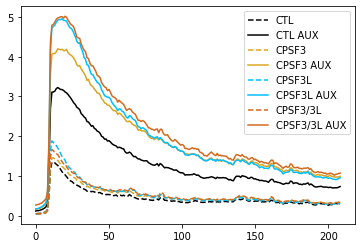

In [26]:
for i in range(0,len(averages),1):
    plt.plot(spl.csumsmooth(averages[i],1), label=labels[i], color=colors[i], linestyle=lstyle[i])
    #plt.fill_between(np.linspace(0,210,210), averages[i]-stddev[i], averages[i]+stddev[i], color=colors[1], alpha=0.25)
plt.legend()
#PdfPages.savefig('test_new_meta.pdf'.format("all", fig))

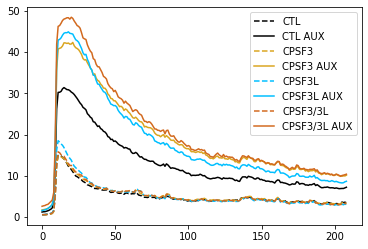

In [27]:
for i in range(0,len(averages_sf),1):
    plt.plot(spl.csumsmooth(averages_sf[i],1), label=labels[i], color=colors[i], linestyle=lstyle[i])
    #plt.fill_between(np.linspace(0,200,200), averages[i]-stddev[i], averages[i]+stddev[i])
plt.legend()

# simple smoothing

In [29]:
#averages = [i*12 for i in averages]
averages = averages_sf
#stddev = [spl.csumsmooth(i,1) for i in stddev]
diff = [averages[i]-averages[0] for i in range(len(averages))]

#fucking smoothing squashing the damn vectors

bps = len(averages[0])

<ipython-input-29-5629e8c360da>:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  averages = np.array([averages[:4],averages_sf[4:]])


TypeError: unsupported operand type(s) for -: 'list' and 'list'

In [ ]:
fig, axs = plt.subplots(1,2, figsize=(15,6), sharex=True, sharey=True)

#each plot showing absolute ctrl as horizontal line(diff[0]) and the relevant
axs[0].plot(averages[0],color=colors[0], linestyle='solid', label=labels[0])
axs[0].plot(averages[2],color=colors[2],linestyle="solid", label=labels[2])
axs[0].plot(averages[4],color=colors[4],linestyle="solid", label=labels[4])
axs[0].plot(averages[6],color=colors[6],linestyle="solid", label=labels[6])
#axs[0].fill_between(np.linspace(0,bps,bps), averages[0]-stddev[0], averages[0]+stddev[0],color=colors[0], alpha=0.25)
#axs[0].fill_between(np.linspace(0,bps,bps), averages[2]-stddev[2], averages[2]+stddev[2],color=colors[2], alpha=0.25)
#axs[0].fill_between(np.linspace(0,bps,bps), averages[4]-stddev[4], averages[4]+stddev[4],color=colors[4], alpha=0.25)
#axs[0].fill_between(np.linspace(0,bps,bps), averages[6]-stddev[6], averages[6]+stddev[6],color=colors[6], alpha=0.25)


axs[1].plot(averages[1],color=colors[1], label=labels[1])
#axs[1].fill_between(np.linspace(0,bps,bps), averages[1]-stddev[1], averages[1]+stddev[1],color=colors[1], alpha=0.25)

axs[1].plot(averages[3],color=colors[3], label=labels[3])
#axs[1].fill_between(np.linspace(0,bps,bps), averages[3]-stddev[3], averages[3]+stddev[3],color=colors[3], alpha=0.25)

axs[1].plot(averages[5],color=colors[5], label=labels[5])
#axs[1].fill_between(np.linspace(0,bps,bps), averages[5]-stddev[5], averages[5]+stddev[5],color=colors[5], alpha=0.25)

axs[1].plot(averages[7],color=colors[7], label=labels[7])
#axs[1].fill_between(np.linspace(0,bps,bps), averages[7]-stddev[7], averages[7]+stddev[7],color=colors[7], alpha=0.25)

#plt.xticks([0,50,100,150,200],["TSS","5kb","10kb","15kb","20kb"])

axs[0].legend()
axs[1].legend()

fig.text(0.04, 0.5, 'delta log2coverage', va='center', rotation='vertical')
#plt.suptitle('{0}, n = {1}'.format(subset[6].unique()[0],len(beddf)))
#plt.suptitle('{0}, n = {1}'.format("All transcripts",len(subset)))
#PdfPages.savefig('meta_{0}.pdf'.format(subset[6].unique()[0]), fig)
#PdfPages.savefig('meta_{0}.pdf'.format("split", fig))
plt.show()

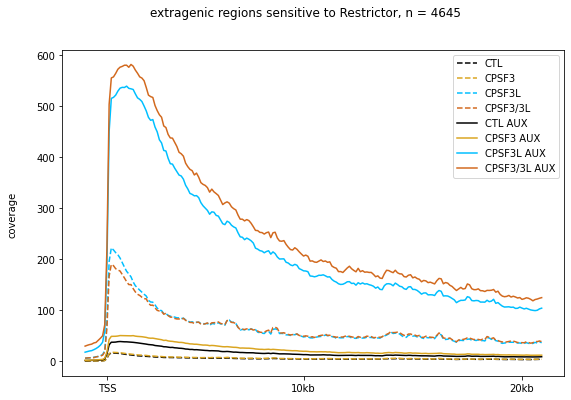

In [22]:
fig, axs = plt.subplots(1,1, figsize=(9,6), sharex=True, sharey=True)

#each plot showing absolute ctrl as horizontal line(diff[0]) and the relevant
axs.plot(averages[0],color=colors[0], linestyle='dashed', label=labels[0])
axs.plot(averages[2],color=colors[2],linestyle="dashed", label=labels[2])
axs.plot(averages[4],color=colors[4],linestyle="dashed", label=labels[4])
axs.plot(averages[6],color=colors[6],linestyle="dashed", label=labels[6])
#axs.fill_between(np.linspace(0,bps,bps), averages[0]-stddev[0], averages[0]+stddev[0],color=colors[0], alpha=0.25)
#axs.fill_between(np.linspace(0,bps,bps), averages[2]-stddev[2], averages[2]+stddev[2],color=colors[2], alpha=0.25)
#axs.fill_between(np.linspace(0,bps,bps), averages[4]-stddev[4], averages[4]+stddev[4],color=colors[4], alpha=0.25)
#axs.fill_between(np.linspace(0,bps,bps), averages[6]-stddev[6], averages[6]+stddev[6],color=colors[6], alpha=0.25)


axs.plot(averages[1],color=colors[1], label=labels[1])
#axs.fill_between(np.linspace(0,bps,bps), averages[1]-stddev[1], averages[1]+stddev[1],color=colors[1], alpha=0.25)
#axs.fill_between(np.linspace(0,bps,bps), averages[3]-stddev[3], averages[3]+stddev[3],color=colors[3], alpha=0.25)
#axs.fill_between(np.linspace(0,bps,bps), averages[5]-stddev[5], averages[5]+stddev[5],color=colors[5], alpha=0.25)
#axs.fill_between(np.linspace(0,bps,bps), averages[7]-stddev[7], averages[7]+stddev[7],color=colors[7], alpha=0.25)

axs.plot(averages[3],color=colors[3], label=labels[3])
axs.plot(averages[5],color=colors[5], label=labels[5])
axs.plot(averages[7],color=colors[7], label=labels[7])

plt.xticks([10,100,200],["TSS","10kb","20kb"])
#plt.yticks([0.5,1.0])
#plt.xlim([0,150])

axs.legend()

fig.text(0.04, 0.5, 'coverage', va='center', rotation='vertical')
#plt.suptitle('{0}, n = {1}'.format(subset[10].unique()[0],len(beddf)))
plt.suptitle('{0}, n = {1}'.format("extragenic regions sensitive to Restrictor",len(subset)))
#PdfPages.savefig('meta_{0}_round2.pdf'.format(subset[10].unique()[0]), fig)
#PdfPages.savefig('{0}.pdf'.format("sicer_not_csaw", fig))
plt.show()

In [ ]:
fig, axs = plt.subplots(2,2, figsize=(10,8), sharex=True, sharey=True)

#each plot showing absolute ctrl as horizontal line(diff[0]) and the relevant
axs[0][0].plot(diff[0],color=colors[1], linestyle='dashed', label=labels[0])
axs[0][0].plot(diff[1],color=colors[1], label=labels[1])
axs[0][0].fill_between(np.linspace(0,bps,bps), diff[1]-stddev[1], diff[1]+stddev[1],color=colors[1], alpha=0.25)
####
axs[0][1].plot(diff[0],color=colors[1], linestyle='dashed', label=labels[0])
axs[0][1].plot(diff[2],color=colors[2],linestyle="dashed", label=labels[2])
axs[0][1].plot(diff[3],color=colors[3], label=labels[3])

axs[0][1].plot(diff[1],color=colors[1], label=labels[1])

axs[0][1].fill_between(np.linspace(0,bps,bps), diff[3]-stddev[3], diff[3]+stddev[3],color=colors[3], alpha=0.25)
axs[0][1].fill_between(np.linspace(0,bps,bps), diff[2]-stddev[2], diff[2]+stddev[2],color=colors[2], alpha=0.25)

####
axs[1][0].plot(diff[0],color=colors[1], linestyle='dashed', label=labels[0])
axs[1][0].plot(diff[4],color=colors[4],linestyle="dashed", label=labels[4])
axs[1][0].plot(diff[5],color=colors[5], label=labels[5])

axs[1][0].plot(diff[1],color=colors[1], label=labels[1])

axs[1][0].fill_between(np.linspace(0,bps,bps), diff[4]-stddev[4], diff[4]+stddev[4],color=colors[4], alpha=0.25)
axs[1][0].fill_between(np.linspace(0,bps,bps), diff[5]-stddev[5], diff[5]+stddev[5],color=colors[5], alpha=0.25)

###
axs[1][1].plot(diff[0],color=colors[1], linestyle='dashed', label=labels[0])
axs[1][1].plot(diff[6],color=colors[6],linestyle="dashed", label=labels[6])
axs[1][1].plot(diff[7],color=colors[7], label=labels[7])

axs[1][1].plot(diff[1],color=colors[1], label=labels[1])

axs[1][1].fill_between(np.linspace(0,bps,bps), diff[6]-stddev[6], diff[6]+stddev[6],color=colors[6], alpha=0.25)
axs[1][1].fill_between(np.linspace(0,bps,bps), diff[7]-stddev[7], diff[7]+stddev[7],color=colors[7], alpha=0.25)

#plt.xticks([0,50,100,150,200],["TSS","5kb","10kb","15kb","20kb"])

axs[0][0].legend()
axs[1][0].legend()
axs[0][1].legend()
axs[1][1].legend()

fig.text(0.04, 0.5, r'$\Delta$ coverage (RPKM)', va='center', rotation='vertical')
#plt.suptitle('{0}, n = {1}'.format(subset[9].unique()[0],len(beddf)))
plt.suptitle('{0}, n = {1}'.format("All transcripts, compared to control condition",len(subset)))
#PdfPages.savefig('meta_{0}.pdf'.format(subset[6].unique()[0]), fig)
#PdfPages.savefig('meta_{0}_poster.pdf'.format("all", fig))
plt.show()

In [ ]:
diff2 = [averages[i]-averages[1] for i in range(len(averages))]

In [ ]:
#differences between aux-treated sets - those are indices 1,3,5 and 7

fig, axs = plt.subplots(2,2, figsize=(10,8), sharex=True, sharey=True)

#each plot showing absolute ctrl as horizontal line(diff[0]) and the relevant
#axs[0][0].plot(diff2[0],color=colors[1], linestyle='dashed', label=labels[0])
axs[0][0].plot(averages[1],color=colors[1], label=labels[1])
axs[0][0].fill_between(np.linspace(0,bps,bps), averages[1]-stddev[1], averages[1]+stddev[1],color=colors[1], alpha=0.25)

axs[0][1].plot(diff2[1],color=colors[1], linestyle='solid', label=labels[1])
#axs[0][1].plot(diff2[2],color=colors[2],linestyle="dashed", label=labels[2])
axs[0][1].plot(diff2[3],color=colors[3], label=labels[3])
axs[0][1].fill_between(np.linspace(0,bps,bps), diff2[3]-stddev[3], diff2[3]+stddev[3],color=colors[3], alpha=0.25)
#axs[0][1].fill_between(np.linspace(0,bps,bps), diff2[2]-stddev[2], diff2[2]+stddev[2],color=colors[2], alpha=0.25)

axs[1][0].plot(diff2[1],color=colors[1], linestyle='solid', label=labels[1])
#axs[1][0].plot(diff2[4],color=colors[4],linestyle="dashed", label=labels[4])
axs[1][0].plot(diff2[5],color=colors[5], label=labels[5])
#axs[1][0].fill_between(np.linspace(0,bps,bps), diff2[4]-stddev[4], diff2[4]+stddev[4],color=colors[4], alpha=0.25)
axs[1][0].fill_between(np.linspace(0,bps,bps), diff2[5]-stddev[5], diff2[5]+stddev[5],color=colors[5], alpha=0.25)

axs[1][1].plot(diff2[1],color=colors[1], linestyle='solid', label=labels[1])
#axs[1][1].plot(diff2[6],color=colors[6],linestyle="dashed", label=labels[6])
axs[1][1].plot(diff2[7],color=colors[7], label=labels[7])
#axs[1][1].fill_between(np.linspace(0,bps,bps), diff2[6]-stddev[6], diff2[6]+stddev[6],color=colors[6], alpha=0.25)
axs[1][1].fill_between(np.linspace(0,bps,bps), diff2[7]-stddev[7], diff2[7]+stddev[7],color=colors[7], alpha=0.25)

plt.xticks([0,50,100,150,200],["TSS","5kb","10kb","15kb","20kb"])

axs[0][0].legend()
axs[1][0].legend()
axs[0][1].legend()
axs[1][1].legend()

fig.text(0.04, 0.5, r'$\Delta$ coverage', va='center', rotation='vertical')
#plt.suptitle('{0}, n = {1}'.format(subset[9].unique()[0],len(beddf)))
plt.suptitle('{0}, n = {1}'.format("All transcripts, compared to ZC3H4 depletion",len(subset)))
#PdfPages.savefig('meta_{0}.pdf'.format(subset[6].unique()[0]), fig)
#PdfPages.savefig('meta_{0}.pdf'.format("all", fig))
plt.show()

# profiles

In [ ]:
indiv = list(zip(regionlistall, rep3[0], rep3[7]))

In [ ]:
fig = plt.figure(figsize=(20,20))
start = 100
for i in range(start,start+25):
    plt.subplot(5,5,i+1-start)
    #plt.xticks([])
    plt.grid(False)
    plt.plot(indiv[i][1])
    plt.plot(indiv[i][2])
    plt.xlabel("{0}".format(indiv[i][0]))
fig.patch.set_facecolor('white')
#plt.savefig('4GM1.png')
plt.show()

In [ ]:
refbed[refbed[3]=="GAPDH"]

In [ ]:
np.shape(bothstrandsall)

In [ ]:
averagesallreps = np.mean(np.mean(allreps, axis=0), axis=1)